# Detecting Heavy Drinking Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from tqdm import tqdm

## Gathering Accelerometer Data

In [2]:
accel_data = pd.read_parquet("all_accelerometer_data.parquet")

In [3]:
accel_data

,time,pid,x,y,z
0,2017-05-02 14:04:42.409,SA0297,0.075800,0.027300,-0.010200
1,2017-05-02 14:04:42.455,SA0297,-0.035900,0.079400,0.003700
2,2017-05-02 14:04:42.500,SA0297,-0.242700,-0.086100,-0.016300
3,2017-05-02 14:04:43.945,SA0297,-0.288800,0.051400,-0.014500
4,2017-05-02 14:04:43.953,SA0297,-0.041300,-0.018400,-0.010500
...,...,...,...,...,...
14057560,2017-05-03 16:34:08.196,CC6740,-0.133956,0.124726,-0.010736
14057561,2017-05-03 16:34:08.220,CC6740,-0.100764,0.180872,0.046449
14057562,2017-05-03 16:34:08.245,CC6740,-0.131853,0.195934,0.181088
14057563,2017-05-03 16:34:08.270,CC6740,-0.149704,0.194482,0.202393


## Gathering TAC Data

In [4]:
pids = list(accel_data['pid'].unique())
pids

['SA0297',
 'PC6771',
 'BK7610',
 'DC6359',
 'MC7070',
 'MJ8002',
 'BU4707',
 'JR8022',
 'HV0618',
 'SF3079',
 'JB3156',
 'CC6740',
 'DK3500']

In [ ]:
pid_tac_dfs = []

for pid in pids:
    pid_tac = pd.read_csv(f"data/clean_tac/{pid}_clean_TAC.csv")
    pid_tac = pid_tac.rename(columns={"timestamp":"time"})
    pid_tac['time'] = pd.to_datetime(pid_tac['time'], unit='s')
    pid_tac['pid'] = pid
    pid_tac = pid_tac[['time', 'pid', 'TAC_Reading']]

    pid_tac_dfs.append(pid_tac)

In [ ]:
all_tac_df = pd.concat(pid_tac_dfs, axis=0)

In [ ]:
all_tac_df['TAC_class'] = 0
all_tac_df.loc[all_tac_df['TAC_Reading'] >= 0.08, 'TAC_class'] = 1

In [ ]:
all_tac_df

,time,pid,TAC_Reading,TAC_class
0,2017-05-02 09:18:43,SA0297,-0.010229,0
1,2017-05-02 09:49:06,SA0297,-0.002512,0
2,2017-05-02 09:54:23,SA0297,0.003249,0
3,2017-05-02 09:59:39,SA0297,0.005404,0
4,2017-05-02 10:04:55,SA0297,0.003377,0
...,...,...,...,...
46,2017-05-03 07:34:28,DK3500,0.011820,0
47,2017-05-03 08:04:52,DK3500,0.011012,0
48,2017-05-03 08:35:16,DK3500,0.010660,0
49,2017-05-03 09:05:38,DK3500,0.011030,0


In [ ]:
# all_tac_df.to_parquet("all_tac_data.parquet")

In [ ]:
all_tac_df = pd.read_parquet("all_tac_data.parquet")

## Reconciling Feature and Target Data

In [40]:
# adding a mergable "second" column
accel_data['seconds'] = accel_data['time'].dt.floor('s')
all_tac_df = all_tac_df.rename(columns={"time": "seconds"})

In [42]:
merged_df = pd.merge(accel_data, all_tac_df, on=['pid', 'seconds'], how="left")

In [48]:
merged_df.drop(columns=['seconds', 'TAC_Reading'], inplace=True)

In [51]:
# assigning the first reading of each pid to be 0 (sober) before forward filling

merged_df['pid_count'] = merged_df.groupby('pid').cumcount()
merged_df.loc[merged_df['pid_count'] == 0, 'TAC_class'] = 0
merged_df.drop(columns='pid_count', inplace=True)

In [54]:
# forward filling the TAC_class field
# start sober, sober util intoxicated read, intoxicated until next sober reading

merged_df['TAC_class'] = merged_df['TAC_class'].fillna(method='ffill')

In [55]:
merged_df

,time,pid,x,y,z,TAC_class
0,2017-05-02 14:04:42.409,SA0297,0.075800,0.027300,-0.010200,0.0
1,2017-05-02 14:04:42.455,SA0297,-0.035900,0.079400,0.003700,0.0
2,2017-05-02 14:04:42.500,SA0297,-0.242700,-0.086100,-0.016300,0.0
3,2017-05-02 14:04:43.945,SA0297,-0.288800,0.051400,-0.014500,0.0
4,2017-05-02 14:04:43.953,SA0297,-0.041300,-0.018400,-0.010500,0.0
...,...,...,...,...,...,...
14057560,2017-05-03 16:34:08.196,CC6740,-0.133956,0.124726,-0.010736,0.0
14057561,2017-05-03 16:34:08.220,CC6740,-0.100764,0.180872,0.046449,0.0
14057562,2017-05-03 16:34:08.245,CC6740,-0.131853,0.195934,0.181088,0.0
14057563,2017-05-03 16:34:08.270,CC6740,-0.149704,0.194482,0.202393,0.0


In [60]:
# Percentage of the data representing sober readings
round((merged_df['TAC_class'] == 0).sum() / len(merged_df) * 100, 2)

82.53

In [14]:
merged_df = pd.read_parquet("merged_data.parquet")

merged_df

,time,pid,x,y,z,magnitude,XYZ_sum,TAC_class
0,2017-05-02 14:04:42.409,SA0297,0.075800,0.027300,-0.010200,0.081209,0.092900,0.0
1,2017-05-02 14:04:42.455,SA0297,-0.035900,0.079400,0.003700,0.087217,0.047200,0.0
2,2017-05-02 14:04:42.500,SA0297,-0.242700,-0.086100,-0.016300,0.258035,-0.345100,0.0
3,2017-05-02 14:04:43.945,SA0297,-0.288800,0.051400,-0.014500,0.293697,-0.251900,0.0
4,2017-05-02 14:04:43.953,SA0297,-0.041300,-0.018400,-0.010500,0.046417,-0.070200,0.0
...,...,...,...,...,...,...,...,...
14057560,2017-05-03 16:34:08.196,CC6740,-0.133956,0.124726,-0.010736,0.183347,-0.019966,0.0
14057561,2017-05-03 16:34:08.220,CC6740,-0.100764,0.180872,0.046449,0.212192,0.126556,0.0
14057562,2017-05-03 16:34:08.245,CC6740,-0.131853,0.195934,0.181088,0.297604,0.245169,0.0
14057563,2017-05-03 16:34:08.270,CC6740,-0.149704,0.194482,0.202393,0.318115,0.247170,0.0


## Attempting to Balance Data

In [16]:
def plot_feature_vs_feature(df, feature_x, feature_y, size=10000):
    # Set seaborn style
    sns.set_style("whitegrid")

    df_subset = df.sample(size)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=feature_x, y=feature_y, hue='TAC_class', data=df_subset, palette='viridis', s=10)
    plt.title(f'{feature_x} vs. {feature_y} Visualization')
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.legend(title='TAC Class', loc='upper right')
    plt.show()

In [17]:
def percent_drunk(df):
    return round(np.sum(df['TAC_class']) / len(df), 3)

In [21]:
# examining data balance based on magnitude of movement
cutoff = datetime(2017, 5, 3, 3, 0)

In [37]:
for pid in pids:
    pid_df = merged_df.loc[merged_df['pid'] == pid]
    drunk_prop = percent_drunk(pid_df)
    after_3am_drunk_prop = percent_drunk(pid_df.loc[pid_df['time'] > cutoff])
    before_3am_drunk_prop = percent_drunk(pid_df.loc[pid_df['time'] <= cutoff])
    print(pid)
    print(f"{drunk_prop * 100}% drunk total")
    print(f"{after_3am_drunk_prop * 100}% drunk after 3am")
    print(f"{before_3am_drunk_prop * 100}% drunk before 3am")
    print("-------------------")


SA0297
11.1% drunk total
0.2% drunk after 3am
35.4% drunk before 3am
-------------------
PC6771
8.1% drunk total
1.4000000000000001% drunk after 3am
27.700000000000003% drunk before 3am
-------------------


/var/folders/kk/v1dq6w817kb25skcwjv3tgyw0000gn/T/ipykernel_18766/3547373032.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return round(np.sum(df['TAC_class']) / len(df), 3)


BK7610
26.8% drunk total
nan% drunk after 3am
26.8% drunk before 3am
-------------------
DC6359
44.2% drunk total
nan% drunk after 3am
44.2% drunk before 3am
-------------------
MC7070
53.900000000000006% drunk total
24.0% drunk after 3am
58.9% drunk before 3am
-------------------
MJ8002
34.0% drunk total
16.8% drunk after 3am
39.0% drunk before 3am
-------------------
BU4707
22.5% drunk total
nan% drunk after 3am
22.5% drunk before 3am
-------------------
JR8022
43.2% drunk total
nan% drunk after 3am
43.2% drunk before 3am
-------------------
HV0618
3.1% drunk total
0.0% drunk after 3am
15.4% drunk before 3am
-------------------
SF3079
44.9% drunk total
36.4% drunk after 3am
46.0% drunk before 3am
-------------------
JB3156
28.499999999999996% drunk total
18.9% drunk after 3am
29.299999999999997% drunk before 3am
-------------------
CC6740
8.7% drunk total
1.0999999999999999% drunk after 3am
24.7% drunk before 3am
-------------------
DK3500
5.0% drunk total
2.3% drunk after 3am
24.5% 

In [42]:
for pid in pids:
    pid_df = merged_df.loc[merged_df['pid'] == pid]
    drunk_prop = percent_drunk(pid_df.loc[pid_df['magnitude'] < .05])

In [41]:
percent_drunk(merged_df)

0.175

In [53]:
before_3am = merged_df.loc[merged_df['time'] < cutoff]

percent_drunk(before_3am)

0.322

In [54]:
after_3am = merged_df.loc[merged_df['time'] >= cutoff]

percent_drunk(after_3am)

0.021

In [55]:
percent_drunk(merged_df.query("`magnitude` < 0.02"))

0.132

In [65]:
percent_drunk(before_3am.query("`magnitude` < 0.01"))

0.314

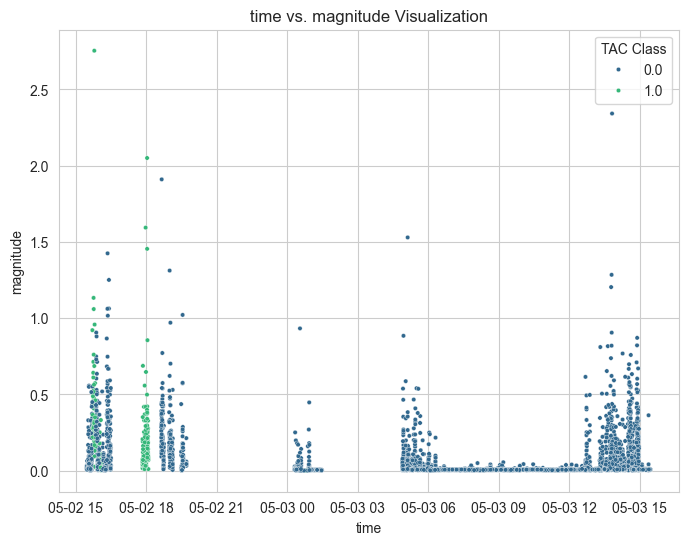

In [55]:
plot_feature_vs_feature(merged_df.loc[merged_df['pid'] == 'HV0618'], 'time', 'magnitude')

In [39]:
# Final Data Balancing Procedure
# Remove data with magnitude of accelerometer data < 0.03 (provides features with low predictive power)
# and data after 03:00 May 3rd, 2017 (night after bar crawl when the data is overwhelmingly classified as sober)

balanced_df = before_3am.query("`magnitude` > 0.03")

In [40]:
len(balanced_df)

4378300

In [41]:
percent_drunk(balanced_df)

0.313

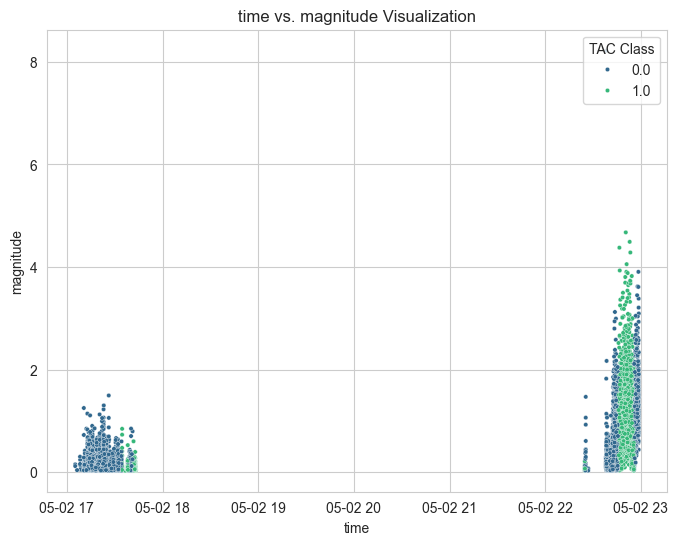

In [42]:
plot_feature_vs_feature(balanced_df.loc[balanced_df['pid'] == 'DK3500'], 'time', 'magnitude')

In [45]:
# balanced_df.to_parquet("balanced_data.parquet")

In [46]:
balanced_df = pd.read_parquet("balanced_data.parquet")

balanced_df

,time,pid,x,y,z,magnitude,XYZ_sum,TAC_class
0,2017-05-02 14:04:42.409,SA0297,0.075800,2.730000e-02,-1.020000e-02,8.120942e-02,0.092900,0.0
1,2017-05-02 14:04:42.455,SA0297,-0.035900,7.940000e-02,3.700000e-03,8.721731e-02,0.047200,0.0
2,2017-05-02 14:04:42.500,SA0297,-0.242700,-8.610000e-02,-1.630000e-02,2.580352e-01,-0.345100,0.0
3,2017-05-02 14:04:43.945,SA0297,-0.288800,5.140000e-02,-1.450000e-02,2.936965e-01,-0.251900,0.0
4,2017-05-02 14:04:43.953,SA0297,-0.041300,-1.840000e-02,-1.050000e-02,4.641659e-02,-0.070200,0.0
...,...,...,...,...,...,...,...,...
7175039,2017-05-03 02:59:59.953,SA0297,0.154100,-6.970000e-02,1.772000e-01,2.449586e-01,0.261600,1.0
7175041,2017-05-03 02:59:59.959,JB3156,7.825448,-1.809008e+08,1.809008e+08,2.558323e+08,7.825448,1.0
7175043,2017-05-03 02:59:59.979,JB3156,9.334992,-1.809008e+08,1.809008e+08,2.558323e+08,9.334992,1.0
7175046,2017-05-03 02:59:59.998,JB3156,7.540538,-1.809008e+08,1.809008e+08,2.558323e+08,7.540538,1.0


## Upsampling Accelerometer Data

In [7]:
def upsample_data_250hz(df):

    upsampled_dfs = {}
    pids = list(df['pid'].unique())

    for pid in tqdm(pids):
        pid_df = df[df['pid'] == pid]

        # there are sometimes multiple instances of the same milisecond.
        pid_df = pid_df.drop_duplicates("time")
        
        pid_df.set_index('time', inplace=True)
        
        upsampled_df = pid_df.resample('4ms').ffill()
        upsampled_df['pid'] = pid
        upsampled_df.reset_index(inplace=True)
        upsampled_df = upsampled_df.dropna()

        print(f"{pid} dataframe length - {len(upsampled_df)}")
        upsampled_dfs[pid] = upsampled_df

    return upsampled_dfs


In [47]:
# Upsampling balanced data

balanced_list_250hz = upsample_data_250hz(balanced_df)

  8%|▊         | 1/13 [00:03<00:42,  3.53s/it]

SA0297 dataframe length - 11629397


 15%|█▌        | 2/13 [00:05<00:32,  2.94s/it]

PC6771 dataframe length - 6196126


 23%|██▎       | 3/13 [00:07<00:27,  2.73s/it]

BK7610 dataframe length - 7974997


 31%|███       | 4/13 [00:09<00:22,  2.53s/it]

DC6359 dataframe length - 8144007


 38%|███▊      | 5/13 [00:12<00:21,  2.64s/it]

MC7070 dataframe length - 10902506


 46%|████▌     | 6/13 [00:14<00:17,  2.43s/it]

MJ8002 dataframe length - 7911200


 54%|█████▍    | 7/13 [00:15<00:12,  2.10s/it]

BU4707 dataframe length - 5104273


 62%|██████▏   | 8/13 [00:17<00:10,  2.12s/it]

JR8022 dataframe length - 8520648


 69%|██████▉   | 9/13 [00:19<00:08,  2.13s/it]

HV0618 dataframe length - 8548259


 77%|███████▋  | 10/13 [00:22<00:06,  2.32s/it]

SF3079 dataframe length - 10300714


 85%|████████▍ | 11/13 [00:24<00:04,  2.30s/it]

JB3156 dataframe length - 10166996


 92%|█████████▏| 12/13 [00:27<00:02,  2.45s/it]

CC6740 dataframe length - 9954844


100%|██████████| 13/13 [00:28<00:00,  2.23s/it]

DK3500 dataframe length - 5302177


In [48]:
for pid in pids:
    drunk_prop = percent_drunk(balanced_list_250hz[pid])
    print(f"{pid}: {drunk_prop * 100}% drunk total")

SA0297: 24.8% drunk total
PC6771: 15.0% drunk total
BK7610: 27.900000000000002% drunk total
DC6359: 39.1% drunk total
MC7070: 26.8% drunk total
MJ8002: 43.7% drunk total
BU4707: 12.2% drunk total
JR8022: 9.8% drunk total
HV0618: 10.9% drunk total
SF3079: 16.7% drunk total
JB3156: 32.0% drunk total
CC6740: 32.5% drunk total
DK3500: 84.0% drunk total


In [49]:
for key in balanced_list_250hz.keys():
    balanced_list_250hz[key].to_parquet(f"{key}_balanced_250hz.parquet")